In [11]:
import os
from pathlib import Path
from typing import Optional

import cv2
import numpy as np
import pandas as pd
import tifffile as tiff
from matplotlib import pyplot as plt

WLS = np.arange(450, 871, 4)

In [12]:
parse_dir = Path(f'../../datasets/Leaf rust june 2024 boxex dai3')
img_files = [
    Path(f"{dir}/{file}")
    for group_name in ['contr', 'exp']
    for dir, subdirs, files in os.walk(parse_dir)
    for file in files if 'tiff' in file and 'REF' in file
]

assert len(img_files) > 50, len(img_files)

len(img_files)

290

   cl_val         mean          std         name
0       0  2180.096063  1524.013432         leaf
1       1  1059.749356   405.409520  black paper
2       2  6258.049367   521.154188  white paper


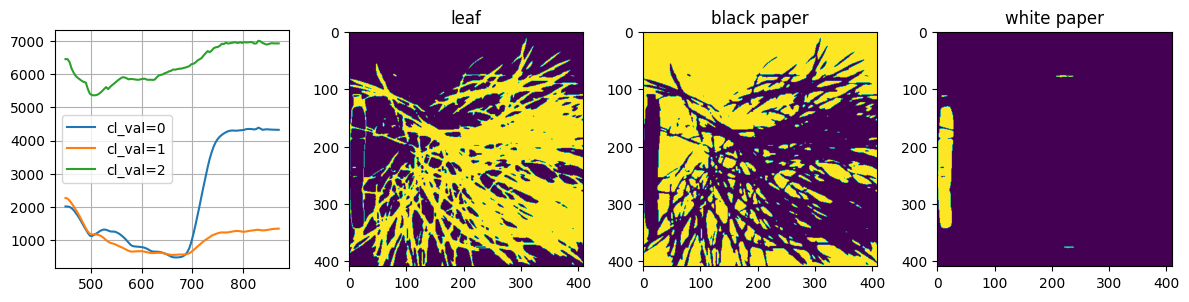

In [13]:
from sklearn.cluster import KMeans

image = tiff.imread(str(img_files[25]))

n_clusters = 3

image_flat = image.reshape(-1,image.shape[-1])
km = KMeans(n_clusters=n_clusters, n_init=3)
cl_preds = km.fit_predict(image_flat)
cl_preds


cl_stats = pd.DataFrame(
    [
        {
            'cl_val':cl_val,
            'mean':image_flat[cl_preds==cl_val].mean(axis=0).mean(),
            'std':image_flat[cl_preds==cl_val].mean(axis=0).std()
        }
        for cl_val in np.unique(cl_preds)
    ]
)


cl_stats.loc[cl_stats.sort_values('mean', ascending=True).index[0], 'name']  = 'black paper'
cl_stats.loc[cl_stats.sort_values('mean', ascending=False).index[0], 'name'] = 'white paper'
cl_stats.loc[cl_stats.sort_values('std', ascending=False).index[0], 'name']  = 'leaf'

print(cl_stats)


fig, axes = plt.subplots(nrows=1,ncols=n_clusters+1,figsize=(n_clusters*4,3))


axes[0].grid()
for cl_val in np.unique(cl_preds):
    axes[0].plot(WLS, image_flat[cl_preds==cl_val].mean(axis=0), label=f"cl_val={cl_val}")
axes[0].legend()



for cl_val in range(n_clusters):
    ax = axes[cl_val+1]

    image_mask = np.zeros(shape=image_flat.shape)
    image_mask[cl_preds==cl_val]=1
    ax.imshow(image_mask.reshape(*image.shape).mean(axis=-1))
    ax.set_title(cl_stats[cl_stats['cl_val']==cl_val].iloc[0]['name'])

plt.tight_layout()
plt.show()



parse snapshot 0/290


C:\Users\danil\AppData\Local\Temp\ipykernel_24652\4016086560.py:16: RuntimeWarning: Mean of empty slice.
  cl_stats = [(cl_val,image[cl_preds_image==cl_val].mean()) for cl_val in np.unique(cl_preds)]
c:\Users\danil\anaconda3\envs\scienv\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


leafrust_boxes_dai3_c2_000_000_snapshot_REF.tiff


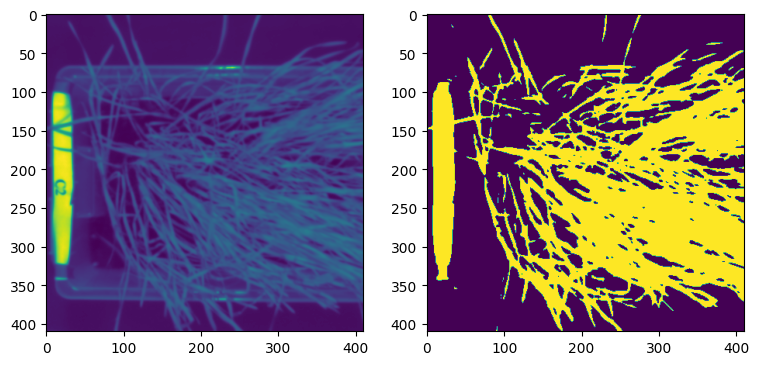

In [14]:
def parse_tiff(img_path: Path, res_dir: Path):
    assert img_path.exists(), str(img_path)

    # if res_dir.exists():
    #     shutil.rmtree(res_dir)

    res_dir.mkdir(exist_ok=True, parents=True)

    image = tiff.imread(str(img_path))
    
    image_flat = image.reshape(-1,image.shape[-1])
    km = KMeans(n_clusters=2, n_init=3)
    cl_preds_flat = km.fit_predict(image_flat)
    cl_preds_image = cl_preds_flat.reshape(image.shape[0:2])

    cl_stats = [(cl_val,image[cl_preds_image==cl_val].mean()) for cl_val in np.unique(cl_preds)]
    # print(cl_stats)
    max_cl = max(cl_stats,key=lambda x:x[1])[0]

    # curr_df = pd.DataFrame(
    #     [
    #         {1.: px, 2.: py, **{WLS[ch_i]: pv for ch_i, pv in enumerate(image[px, py])}}
    #         for px in range(image.shape[0])
    #         for py in range(image.shape[1])
    #         if cl_preds_image[px, py]==max_cl
    #     ]
    # )
    
    # curr_df.to_csv(res_dir.joinpath(f"{snap_name}.csv"), index=False)
    
    image_masked = np.zeros(shape=image.shape[0:2])
    image_masked[cl_preds_image==max_cl] = 1.


    fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(9,6))
     
    axes[0].imshow(image.mean(axis=-1))
    axes[1].imshow(image_masked)
    
    print(img_path.name)

    plt.savefig(res_dir.joinpath(f"{img_path.name}.png"))
    plt.show()


for i, img_file in enumerate(img_files[13:14]):
    print(f"parse snapshot {i}/{len(img_files)}")
    parse_tiff(
        img_path=img_file,
        res_dir=Path(f'csv/{parse_dir.name}').joinpath(img_file.parent.parent.name)
    )
